In [1]:
%load_ext autotime

In [134]:
import gc
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
from bs4 import BeautifulSoup
%matplotlib inline

time: 4.55 ms


#### download data from kaggle

Data can be downloaded from https://www.kaggle.com/stackoverflow/stacksample

#### load data , filter , merge

##### load and filter questions

In [135]:
questions = pd.read_csv('questions.csv.zip', encoding="ISO-8859-1",
                        usecols=['Id', 'Score', 'Title', 'Body'])
# filter questions greater than 5 upvotes
questions = questions[questions['Score'] > 5]
print(questions.shape)
questions.head()

(72950, 4)


,Id,Score,Title,Body
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


time: 52.9 s


##### load and group tags

In [136]:
tags = pd.read_csv('tags.csv.zip', encoding="ISO-8859-1")
tags['Tag'] = tags['Tag'].astype(str)
# group the tags by questions Id and join the tags with comma
tags = tags.groupby("Id")['Tag'].apply(lambda tags: ','.join(tags))
tags.reset_index()
tags = pd.DataFrame({'Id': tags.index, 'Tags': tags.values})
tags.head(5)

,Id,Tags
0,80,"flex,actionscript-3,air"
1,90,"svn,tortoisesvn,branch,branching-and-merging"
2,120,"sql,asp.net,sitemap"
3,180,"algorithm,language-agnostic,colors,color-space"
4,260,"c#,.net,scripting,compiler-construction"


time: 3min 18s


##### merge questions with tags on Id

In [137]:
data_set = questions.merge(tags, on='Id')
del questions
gc.collect()

1876894

time: 4.02 s


##### drop the id and score since we don't need them for next stages

In [138]:
data_set.drop(columns=['Id', 'Score'], inplace=True)

time: 33.8 ms


In [139]:
data_set.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"flex,actionscript-3,air"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"svn,tortoisesvn,branch,branching-and-merging"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"sql,asp.net,sitemap"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"algorithm,language-agnostic,colors,color-space"
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"c#,.net,scripting,compiler-construction"


time: 11.5 ms


#### Analysis Tags

##### replace the tags string with tags array

In [140]:
data_set.Tags = data_set.Tags.apply(lambda x: x.split(','))

time: 67 ms


In [141]:
data_set.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"


time: 8.86 ms


##### cretae a list of all tags and create a subset list of unique tags

In [142]:
tags_list = [tag for row in data_set.Tags.values for tag in row]
unique_tags = list(set(tags_list))
len(unique_tags)

14883

time: 60.7 ms


In [143]:
unique_tags

['document.write',
 'mapping',
 'flowdocumentscrollviewer',
 'form-data',
 'jax-ws',
 'pymssql',
 'packet-capture',
 'share',
 'custom-controls',
 'json-rpc',
 'higher-rank-types',
 'shiny',
 'server-side-validation',
 'ssmtp',
 'git-commit',
 'onmousemove',
 'browser-tab',
 'phpfox',
 'linkedin-api',
 'model-view-controller',
 'skaction',
 'window.location',
 'undefined-reference',
 'easynetq',
 'producer-consumer',
 'conditional-comments',
 'xmodmap',
 'cbc-mac',
 'jython',
 'spinlock',
 'exp',
 'mnemonics',
 'javacv',
 'toolbar',
 'allocator',
 'httpcontext.cache',
 'ppi',
 '.htaccess',
 'haml',
 'server-explorer',
 'elmah.mvc',
 'project-management',
 'validating',
 'phpactiverecord',
 'meta-inf',
 'vmware-player',
 'movable',
 'piping',
 'mac-app-store',
 'codeception',
 'boost-iostreams',
 'mpmovieplayercontroller',
 'css-animations',
 'devops',
 'capistrano3',
 'mjpeg',
 'naming',
 'federated-identity',
 'isnullorempty',
 'jsobject',
 'xml-parsing',
 'flops',
 'circleci',
 'dom-

time: 17.2 ms


##### check the frequency of tags appeared in the dataset and take most common 100 tags 

In [144]:
tags_frequency = nltk.FreqDist(tags_list)
top_tags_dict = tags_frequency.most_common(100)
top_tags = [tag_tuple[0] for tag_tuple in top_tags_dict]

time: 200 ms


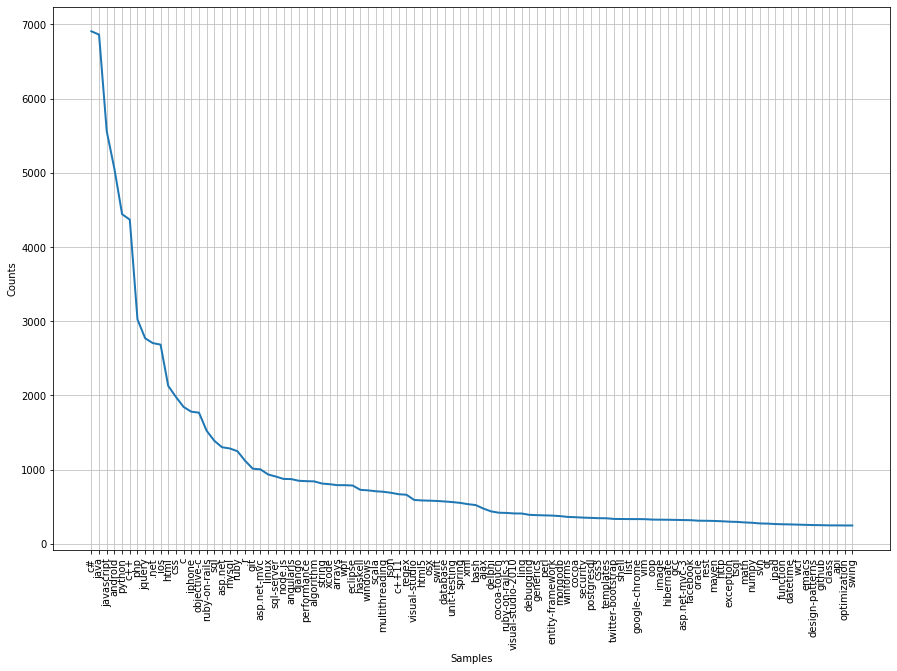

time: 2.19 s


In [145]:
fig, ax = plt.subplots(figsize=(15, 10))
tags_frequency.plot(100, cumulative=False)

##### remove uncommon tags and drop null rows for tags

In [146]:
'java' in top_tags

True

time: 2.57 ms


###### Remove uncommon tags 

In [147]:
def remove_uncommon_tag(tags):
    filtered = []
    for i in range(len(tags)):
        if tags[i] in top_tags:
            filtered.append(tags[i])
    if len(filtered):
        return filtered
    else:
        return None

time: 1.42 ms


In [148]:
data_set.Tags = data_set.Tags.apply(lambda x: remove_uncommon_tag(x))
data_set.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,None
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"


time: 545 ms


###### drop the rows which have none for the tags

In [149]:
data_set.dropna(subset=['Tags'], inplace=True)
data_set.shape

(63167, 3)

time: 22.4 ms


In [150]:
data_set.Tags.isna().sum()

0

time: 8.74 ms


In [151]:
data_set.head()

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"


time: 11.4 ms


#### cleaning the body & title

##### explore the content

In [152]:
data_set[data_set.apply(lambda row: row.astype(str).str.lower(
).str.contains('create table `users`').any(), axis=1) == True]

,Title,Body,Tags
16357,sql error errno: 121,<pre><code>CREATE TABLE `users` (\n `UID` INT...,"[mysql, sql]"
33134,Rake aborted... table 'users' already exists,<p>I have created a database with devise and t...,"[ruby-on-rails, ruby, database]"
33153,MySQL query performance dilemma: enum vs tables,<p>I currently have this schema:</p>\n\n<pre><...,"[mysql, performance]"
46914,Rails creating migration to add columns to tab...,"<p>I have a model created called ""users"" and i...","[ruby-on-rails, ruby, ruby-on-rails-3]"
55148,Laravel 4 cannot run whole RAW queries,<p>I would like to use the DB class of laravel...,"[php, mysql]"


time: 57.2 s


In [153]:
data_set[data_set.apply(lambda row: row.astype(
    str).str.lower().str.contains('<pre>').any(), axis=1) == True]

,Title,Body,Tags
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
11,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,"[c#, asp.net]"
23,Convert HashBytes to VarChar,<p>I want to get the MD5 Hash of a string valu...,"[sql, sql-server]"
32,Converting ARBG to RGB with alpha blending,<p>Let's say that we have an ARGB color:</p>\n...,[c#]
34,MySQL/Apache Error in PHP MySQL query,<p>I am getting the following error:</p>\n\n<b...,"[php, mysql]"
...,...,...,...
72944,STL list very bad performance,"<p>It's supposed that ""push_back"" and ""pop_fro...","[c++, list]"
72945,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...",[python]
72946,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,[python]
72948,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,[c++]


time: 55.4 s


In [154]:
text = data_set['Body'][4]
text

'<p>I have a little game written in C#. It uses a database as back-end. It\'s \na <a href="http://en.wikipedia.org/wiki/Collectible_card_game">trading card game</a>, and I wanted to implement the function of the cards as a script.</p>\n\n<p>What I mean is that I essentially have an interface, <code>ICard</code>, which a card class implements (<code>public class Card056 : ICard</code>) and which contains function that are called by the game.</p>\n\n<p>Now, to make the thing maintainable/moddable, I would like to have the class for each card as source code in the database and essentially compile it on first use. So when I have to add/change a card, I\'ll just add it to the database and tell my application to refresh, without needing any assembly deployment (especially since we would be talking about 1 assembly per card which means hundreds of assemblies).</p>\n\n<p>Is that possible? Register a class from a source file and then instantiate it, etc.</p>\n\n<pre><code>ICard Cards[current] =

time: 7.99 ms


In [156]:
text = data_set['Body'][16357]
text

'<pre><code>CREATE TABLE `users` (\n  `UID` INT UNSIGNED NOT NULL AUTO_INCREMENT ,\n  `username` VARCHAR(45) NOT NULL ,\n  `password` VARCHAR(100) NULL ,\n  `name` VARCHAR(100) NULL ,\n  `gender` BIT NULL ,\n  `email` VARCHAR(255) NULL ,\n  `phone` VARCHAR(30) NOT NULL ,\n  `verified` BIT NOT NULL DEFAULT 0 ,\n  `time_zone` INT NULL ,\n  `time_register` DATETIME NULL ,\n  `time_active` DATETIME NULL ,\n  PRIMARY KEY (`UID`) ,\n  UNIQUE INDEX `username_UNIQUE` (`username` ASC) ,\n  INDEX `verified_INDEX` (`verified` ASC) )\nENGINE = InnoDB\nDEFAULT CHARACTER SET = utf8;\n\n\n-- -----------------------------------------------------\n-- Table `companies`\n-- -----------------------------------------------------\nCREATE TABLE `companies` (\n  `CID` INT UNSIGNED NOT NULL AUTO_INCREMENT ,\n  `name` VARCHAR(45) NOT NULL ,\n  `address` VARCHAR(100) NULL ,\n  `email` VARCHAR(255) NULL ,\n  `phone` VARCHAR(30) NULL ,\n  `link` TEXT NULL ,\n  `image_small` TEXT NULL ,\n  `image_large` TEXT NULL ,

time: 5.49 ms


##### preprocessing 

In [158]:
contraction_dict = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                    "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
# from pycontractions import Contractions
# cont = Contractions(kv_model=model)
# cont.load_models()
# def expand_contractions(text):
#     """expand shortened words, e.g. don't to do not"""
#     text = list(cont.expand_texts([text], precise=True))[0]
#     return text


def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re


contractions, contractions_re = _get_contractions(contraction_dict)


def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

time: 9.18 ms


In [159]:
puncts = [',',  '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=',  '*', '\\', '•',  '~', '@', '£',
          '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
          '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
# + . # - are excluded


def remove_punc(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            #             x = x.replace(punct, f' {punct} ')
            x = x.replace(punct, '')
    return x.strip()


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

time: 4.36 ms


In [160]:
# def remove_html_tags(text):
#     """function to clean html tags from a string"""
#     return BeautifulSoup(text).get_text()


# def remove_code(text):
#     """function to clean codes from a string"""
#     clean = re.compile("<code>(.*?)<\/code>")
#     return re.sub(clean, '', text)
def pre_remove(html):
    """function to clean codes &  html tags from a html string"""
    soup = BeautifulSoup(html)
    removable = ['pre', 'code']
    for tag in soup.findAll():
        if tag.name.lower() in removable:
            tag.extract()
    return soup.get_text()


def remove_pre(text):
    """function to clean codes from a string"""
    clean = re.compile("<pre>.*?<\/pre>")
    return re.sub(clean, '', text)


def clean_text(text):
    html_cleaned = pre_remove(text)
    contraction_restored = replace_contractions(html_cleaned)
    puncts_removed = remove_punc(contraction_restored)
    characters_unicoded = remove_accented_chars(puncts_removed)
    return remove_whitespace(characters_unicoded)

time: 3.35 ms


In [161]:
data_set.columns = [col.lower() for col in data_set.columns.values]
data_set.title = data_set.title.astype(str).str.lower()
data_set.body = data_set.body.astype(str).str.lower()

time: 432 ms


In [162]:
data_set.title = data_set.title.apply(lambda x: clean_text(x))
data_set.body = data_set.body.apply(lambda x: clean_text(x))

time: 1min 57s


In [163]:
data_set['body'][56]

'i am developing a sharepoint application and use .net ajaxcontroltoolkit library we are adding a custom aspx page to the sharepoint. sharepoint 2007 run in quirks mode so i have made some modification to the ajax library to make it behave like it normally should. the problem is the other team already use ajax library and it is a different version with mine. this cause conflict because there could be only one dll in the bin folder with the same name. from what i know .net should be able to handle this situation easily. i have tried using strong name and gac to solve it but it still refer to the dll in the bin folder. if there is no ajaxcontroltoolkit.dll in the bin folder the application will simply fail to load the assembly. if i use complete assembly information on my like this it gives me compiler error cs0433 can someone help me on how to use multiple version of assembly in an application'

time: 3.95 ms


In [165]:
data_set.tags.isna().sum()

0

time: 11.7 ms


In [167]:
data_set['body_len'] = data_set.body.apply(lambda x: len(x))

time: 49.5 ms


In [174]:
data_set['title_len'] = data_set.title.apply(lambda x: len(x))

time: 29.5 ms


In [176]:
data_set.title_len.describe()

count    62739.000000
mean        50.336234
std         18.710482
min          0.000000
25%         37.000000
50%         48.000000
75%         61.000000
max        170.000000
Name: title_len, dtype: float64

time: 26.6 ms


In [171]:
data_set = data_set[data_set.body_len > 50]
data_set.drop(columns=['body_len'])
data_set.reset_index(inplace=True, drop=True)

time: 18 ms


In [177]:
data_set = data_set[data_set.title_len > 5]
data_set.drop(columns=['title_len'])
data_set.reset_index(inplace=True, drop=True)

time: 19.4 ms


In [179]:
data_set.to_pickle('cleaned.pkl')

time: 677 ms


In [178]:
data_set.shape

(62733, 5)

time: 2.43 ms


In [128]:
df = pd.read_pickle('cleaned.pkl')

time: 336 ms


In [129]:
df.head()

,title,body,tags
1,good branching and merging tutorials for torto...,are there any really good tutorials explaining...,[svn]
2,asp.net site maps,has anyone got experience creating sqlbased as...,"[sql, asp.net]"
3,function for creating color wheels,this is something i have pseudosolved many tim...,[algorithm]
4,adding scripting functionality to .net applica...,i have a little game written in c#. it uses a ...,"[c#, .net]"
5,should i use nested classes in this case,i am working on a collection of classes used f...,"[c++, oop, class]"


time: 8.76 ms


In [114]:
df.shape

(63167, 3)

time: 2.67 ms


In [133]:
df.body[2819]

'in log4j there is a feature wherein the system can be initialized to do a configure and watch with an interval. this allows for the log4j system to reload its properties whenever the property file is changed. does the spring framework have such a configuration observer facility wherein the configuration is reloaded when it changed. the configuration that needs reloading is not the springss applicationcontext.xml but various other configuration files that are initialized using the spring initialization beans.'

time: 2.84 ms


In [124]:
dict_ = dict(tags_frequency)

time: 1.69 ms


In [125]:
names = list(dict_.keys())
values = list(dict_.values())

time: 1.03 ms
